In [1]:
# Установка библиоткеи detecto.
!pip install detecto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Загрузка модулей

import numpy as np
import matplotlib.pyplot as plt
import torch
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid

import cv2
import imutils
from cv2 import VideoWriter_fourcc
from imutils.video import VideoStream
from imutils.video import FPS
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
from pathlib import Path

In [3]:
# Подключение гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive
root_dir = Path().cwd()
print(root_dir)

/content/drive/MyDrive
/content/drive/MyDrive


In [5]:
# Пути к сохранённым весам дообученной yolo5 и самой папке с yolo5 (детекция рамки с номером)
model_path_yolo = str(root_dir.joinpath(root_dir, 'yolov5/runs/train/exp2/weights/best.pt'))
yolo_path = str(root_dir.joinpath(root_dir, 'yolov5'))       

# Загрузка yolo и загрузка в неё сохранённых ранее при дообучении весов
model_yolo = torch.hub.load(yolo_path, 'custom', path=model_path_yolo, source='local')

# метки классов для detecto
labels = ['0','1','2','3','4','5','6','7','8','9', 'А', 'В', 'С', 'Е', 'Н', 'К', 'М', 'О', 'Р', 'Т', 'Х', 'У']

# Путь к весам дообученной в detecto модели (детекция и распознавание символов гос. номера)
path_to_weights_detecto =  str(root_dir.joinpath(root_dir, 'detecto/model/model_weights_2.pth'))

model_detecto = core.Model.load(path_to_weights_detecto, labels)


YOLOv5 🚀 2022-9-22 Python-3.7.14 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/

  0%|          | 0.00/160M [00:00<?, ?B/s]

In [6]:
# Функция нужна для получения из yolo5 координатов баундинг бокса рамки с номером по каждому кадру. Принимает на вход кадр.
def get_bboxes(video_frame):

  results = model_yolo([video_frame])

  plates = []
  if results.xyxy[0].shape[0] == 0:
    pass
  else:
    number_of_license_plate = results.xyxy[0].shape[0]
    
    for i in range(0, number_of_license_plate):
      xmin = results.xyxy[0][i][0]
      ymin = results.xyxy[0][i][1]
      xmax = results.xyxy[0][i][2]
      ymax = results.xyxy[0][i][3]
      confidence = results.xyxy[0][i][4]
      plates.append((xmin, ymin, xmax, ymax, confidence))
  return plates 


# Функция нужна для отрисовки рамки с найденным гос. номером номером и confidence на каждом кадре.
# Принимает на вход список баундинг боксов, кадр и порог уверенности
def draw_bboxes(boxes_list, frame, conf, treshold_detecto):
  if len(boxes_list) == 0:
    plate_number = None
        
  else:
    # Отрисовываем рамку с номером, если уверенность выше пороговой 
    for box in boxes_list:
      if box[4] >= conf:
        cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[0]) + (int(box[2])-int(box[0])), int(box[1]) + (int(box[3])-int(box[1]))), (0, 0, 255), 3)
        cv2.putText(frame, str(round(float(box[4]),2)) , (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 0, 255),lineType=cv2.LINE_AA)
        plate_number = frame[int(box[1]): int(box[1]) + (int(box[3])-int(box[1])), int(box[0]): int(box[0]) + (int(box[2])-int(box[0]))]
        clear_output(wait=True)
        cv2_imshow(plate_number)
        
        # Находим и распознаём символы с помощью detecto. Отрисовываем гос. номер на кадре.
        plate_number_symbols = predict_symbols(plate_number, treshold_detecto)
        print(plate_number_symbols)
        cv2.putText(frame, plate_number_symbols , (int(box[0])+40, int(box[1])-10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0),lineType=cv2.LINE_AA)
        
      else:
        plate_number = None
            
  return frame, plate_number


# Функция нужна для детекции и распознавания символов на фрагменте изображения с номером.
# Принимает на вход кадр и порог уверенности
def predict_symbols(image, tresh):

  predictions = model_detecto.predict(image)
  labels, boxes, scores = predictions
  
  # Будем брать только те баундинг боксы, где уверенность выше пороговой
  filtered_indices=np.where(scores>tresh)
  filtered_boxes=boxes[filtered_indices]
  num_list = filtered_indices[0].tolist()
  filtered_labels = [labels[i] for i in num_list]
  
  # Так как оставшиеся после фильтрации метки классов располагаются не в том
  # порядке какой нужен, отсортируем их по xmin их баундинг боксов с помощью словаря. 
  symbols_dict = {}
  number_symbols = filtered_boxes.shape[0]
  for i in range(0,number_symbols):
    symbols_dict[float(filtered_boxes[i][0])] = filtered_labels[i]
  result = "".join(list(dict(sorted(symbols_dict.items())).values()))
    
  return  result    

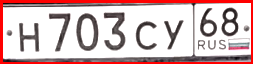

Н703СУ68


In [8]:
# Путь к видео на котором будем искать номер и распознавать его
path_to_video = str(root_dir.joinpath(root_dir, 'VID_20190810_064327.mp4'))          

# Захват видеопотока
video_stream = cv2.VideoCapture(path_to_video)

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
frame_width = int(video_stream.get(3))
frame_height = int(video_stream.get(4))

# Будем выводить обработанное видео с отрисованными номером в отдельный файл 
out = cv2.VideoWriter(str(root_dir.joinpath(root_dir, 'out_video.avi')), fourcc , 25, (frame_width,frame_height))

# Уверенность для yolo и порог для detecto
confidence_yolo = 0.2
treshold_detecto = 0.6

# Инициализация модели
model_detecto = core.Model.load(path_to_weights_detecto, labels)

# Обрабтываем каждый кадр захваченного видеопотока, передаём кадры в ранее написанные функции.
while True:
  (grabbed, frame) = video_stream.read()
  if not grabbed:
    break
  bboxes = get_bboxes(frame)
    
  frame_to_draw, plate_number = draw_bboxes(bboxes, frame, confidence_yolo, treshold_detecto)
  out.write(frame_to_draw)


In [ ]:
# Код читает видео, yolo5 находит рамку с номером, detecto распознает на рамке с номером символы.